In [2]:
import pandas as pd
from compotitions.sql import MSSql
import pickle

sql = MSSql(
    {
        'server': '210.97.193.116',
        'database': 'Stock',
        'user' : 'hanjoo',
        'password' : 'hj7108lee!', 
        'charset':'utf8',
        'port': 41268,
        }
)

In [3]:
data = sql.pd_select(f'''

select 
순위
,유형
,대상수
,날짜
,매수날짜
,평균수익률
,표준편차
,총거래
,승률
,승리수
,단일종목최대수익률
,단일종목최대손실률
From T_BACKTEST_RESULT_20211027 
where 대상수 in ('20')
and 매수날짜 BETWEEN '2013-01-01' AND '2021-01-01' 
order by 단일종목최대손실률 desc
''')

data.to_pickle('backtestresult20_20211116.pkl')

In [4]:
data = sql.pd_select(f'''

-- 평균수익률 가장 높은 유형
select 유형
,count(*) 분기수
,AVG(순위)순위
,MIN(순위)최선순위
,MAX(순위)최악순위
,AVG(평균수익률)평균수익률
,AVG(승률)승률
,AVG(승리수)승리수
,MAX(단일종목최대수익률)단일종목최대수익률
,MIN(단일종목최대손실률)단일종목최대손실률
,대상수
,
case when 매수날짜 BETWEEN '2013-01-01' AND '2018-01-01' then 0 
when 매수날짜 BETWEEN '2018-01-01' AND '2020-01-01' then -1 
when 매수날짜 BETWEEN '2020-01-01' AND '2021-01-01' then 1 else null end 시장
From T_BACKTEST_RESULT_20211027 
where 대상수 in ('20', '100', '200')
and 매수날짜 BETWEEN '2013-01-01' AND '2021-01-01' 
group by 유형, 대상수,
case when 매수날짜 BETWEEN '2013-01-01' AND '2018-01-01' then 0 
when 매수날짜 BETWEEN '2018-01-01' AND '2020-01-01' then -1
when 매수날짜 BETWEEN '2020-01-01' AND '2021-01-01' then 1 else null end
order by 단일종목최대손실률 desc, AVG(평균수익률) desc, AVG(승률) desc
''')

data.to_pickle('backtestresult20211116.pkl')

In [5]:
data = sql.pd_select(f'''


select 유형
,count(*) 분기수
,AVG(순위)순위
,MIN(순위)최선순위
,MAX(순위)최악순위
,AVG(평균수익률)평균수익률
,AVG(승률)승률
,AVG(승리수)승리수
,MAX(단일종목최대수익률)단일종목최대수익률
,MIN(단일종목최대손실률)단일종목최대손실률
,대상수
From T_BACKTEST_RESULT_20211027 
where 대상수 in ('20', '100', '200')
and 매수날짜 BETWEEN '2013-01-01' AND '2021-01-01' 
group by 유형, 대상수
order by AVG(평균수익률) desc, 단일종목최대손실률 desc, AVG(승률) desc

''')

data.to_pickle('backtestresultavg20211116.pkl')

In [23]:
import pandas as pd
import pymssql 
import plotly.express as px
import plotly.graph_objects as go
import qgrid
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import MonthEnd
import numpy as np

# from compotitions.utility import Util
from compotitions.backtest import Backtest
from compotitions.sql import MSSql
from compotitions.simpleLog import SimpleLog
from compotitions.config import Config
from compotitions.file import File
from compotitions.datamanager import DataManager
from compotitions.simple_backtest import Simple_Backtest

%matplotlib inline
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font_path = "C:/Windows/Fonts/gulim.ttc"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rcParams["figure.figsize"] = (14,10) #그림(figure)의 크기. (가로,세로) 인치 단위
plt.rcParams['lines.linewidth'] = 2 #선의 두께
# plt.rcParams['lines.color'] = 'r' #선의 색깔
plt.rcParams['axes.grid'] = True #차트내 격자선(grid) 표시 여부
# 경고메세지 무시용
pd.set_option('mode.chained_assignment',  None) 

In [7]:
df_raw = pd.read_pickle("backtestresult20211116.pkl")

In [8]:
df = df_raw[(df_raw['평균수익률'] > 0) & (df_raw['대상수'] == 20)]
df['평균수익률'] = round(df['평균수익률'] * 100, 3)

In [9]:
dfavg_raw = pd.read_pickle('backtestresultavg20211116.pkl')

In [10]:
dfavg = dfavg_raw[(dfavg_raw['평균수익률'] > 0) & (dfavg_raw['대상수'] == 20)]
dfavg['평균수익률'] = round(dfavg['평균수익률'] * 100, 3)

In [60]:
df20_raw = pd.read_pickle('backtestresult20_20211116.pkl')
df20 = df20_raw.copy()
# df20 = df20_raw[(df20_raw['평균수익률'] > 0) & (df20_raw['대상수'] == 20)]
df20['평균수익률'] = round(df20['평균수익률'] * 100, 3)

In [198]:
dfavg.sort_values('순위')

,유형,분기수,순위,최선순위,최악순위,평균수익률,승률,승리수,단일종목최대수익률,단일종목최대손실률,대상수
17,BPS0매출액_성장률_YOY1영업이익_성장률_QOQ1시가총액0,32,24392,290,110914,14.646,0.598483,11,3.133589,-0.463327,20
93,ROA1부채비율1영업이익_성장률_YOY1시가총액0,32,24864,349,87819,13.646,0.634010,12,2.972414,-0.467593,20
7,ROE1영업이익_성장률_QOQ1영업이익_성장률_YOY1시가총액0,32,25147,1015,127051,14.902,0.654496,12,2.972414,-0.466793,20
19,GPA1PSR0영업이익_성장률_YOY1시가총액0,32,25325,56,78765,14.574,0.659558,12,2.972414,-0.463327,20
3,ROE1EPS0영업이익_성장률_QOQ1시가총액0,32,25523,206,132926,15.206,0.632931,12,3.050074,-0.466793,20
...,...,...,...,...,...,...,...,...,...,...,...
465567,PER1POR1매출액_성장률_YOY0시가총액1,32,110243,6384,150059,0.012,0.419472,8,2.115220,-0.692623,20
463852,영업이익_성장률_YOY0당기순이익_성장률_YOY0자산성장률_QOQ1시가총액1,32,110329,197,155118,0.336,0.406332,8,2.579474,-0.613450,20
464957,BPS1PER1매출액_성장률_YOY0주가변동성1,32,111059,14478,151862,0.146,0.421382,8,2.304130,-0.530665,20
464986,PBR_역수0순차입금비율1매출액_성장률_YOY0영업이익_성장률_YOY0,32,111093,724,155830,0.140,0.393193,7,4.268362,-0.755539,20


In [59]:
df20

,순위,유형,대상수,날짜,매수날짜,평균수익률,표준편차,총거래,승률,승리수,단일종목최대수익률,단일종목최대손실률
0,364,BPS0매출액_성장률_YOY0당기순이익_성장률_YOY1자산성장률_YOY1,20,2020-05-18,2020-03-31,4619.8,0.201238,20,1.00,20,0.970270,0.239193
1,5330,PER1PSR0베타1시가총액0,20,2020-05-18,2020-03-31,3792.2,0.092746,20,1.00,20,0.548077,0.231343
2,4813,BPS0PBR0PER1자산성장률_YOY1,20,2020-05-18,2020-03-31,3828.4,0.150278,20,1.00,20,0.890000,0.224199
3,4813,BPS0PBR_역수1PER1자산성장률_YOY1,20,2020-05-18,2020-03-31,3828.4,0.150278,20,1.00,20,0.890000,0.224199
4,1688,ROA1PER1순차입금비율1베타1,20,2020-05-18,2020-03-31,4193.9,0.146400,20,1.00,20,0.700627,0.214912
...,...,...,...,...,...,...,...,...,...,...,...,...
4987131,121052,BPS1PBR_역수1매출액_성장률_QOQ1주가변동성1,20,2020-08-18,2020-05-18,759.9,0.357770,20,0.60,12,0.923077,-1.000000
4987132,121117,GPA1PBR0EPS1자산성장률_YOY1,20,2020-08-18,2020-05-18,758.9,0.314516,20,0.80,16,0.551282,-1.000000
4987133,121117,GPA1PBR_역수1EPS1자산성장률_YOY1,20,2020-08-18,2020-05-18,758.9,0.314516,20,0.80,16,0.551282,-1.000000
4987134,121111,PBR0PSR0영업이익_성장률_YOY1당기순이익_성장률_YOY1,20,2020-08-18,2020-05-18,759.0,0.308428,20,0.65,13,0.501645,-1.000000


In [18]:
import FinanceDataReader as fdr
symbol = 'KQ11'
df_raw_base = fdr.DataReader(symbol, '2010')

In [20]:
df_raw = df_raw_base[:].copy()

In [24]:
preroll_list = list()
for precount in [1, 5, 10, 30, 60]:
#     precount = 3 # 예측구간
    for i in range(1,30):
        rollcount = precount * i # 예측구간 롤링
        dft = df_raw.copy()
        # 밴드 생성
        dft['rolling_High'] = dft['High'].shift(precount).rolling(window=rollcount, min_periods=1).max() 
        dft['rolling_Low'] = dft['Low'].shift(precount).rolling(window=rollcount, min_periods=1).min()
        dft['rolling_Close'] = dft['Close'].shift(precount).rolling(window=rollcount, min_periods=1).mean()
        dft['rolling_Range'] = dft['rolling_High']-dft['rolling_Low']
        dft['target'] = dft['Close'].shift(precount) - dft['rolling_Range'] * 0.5
        
        # 밴드를 벗어나는 범위 체크
        dft['rolling_In'] = (dft['Close'] <= dft['rolling_High']) & (dft['Close'] >= dft['rolling_Low'])
        # 추세 체크
#         dft['rolling_mean'] = (((dft['Close'].shift(-precount) < dft['rolling_Close']) &
#                                (dft['rolling_Close']-dft['rolling_Low'] < dft['rolling_High']-dft['rolling_Close'])) |
#                                ((dft['Close'].shift(-precount) > dft['rolling_Close']) &
#                                (dft['rolling_Close']-dft['rolling_Low'] > dft['rolling_High']-dft['rolling_Close'])))
        dft['rolling_mean'] = (((dft['Close'].shift(-precount) < dft['Close']) &
                               (dft['rolling_Close']-dft['rolling_Low'] < dft['rolling_High']-dft['rolling_Close'])) |
                               ((dft['Close'].shift(-precount) > dft['Close']) &
                               (dft['rolling_Close']-dft['rolling_Low'] > dft['rolling_High']-dft['rolling_Close'])))
        # 변동성 체크
#         dft['rolling_range'] = (((dft['Close'].shift(-precount) < dft['rolling_Close']) &
#                                (dft['Close'] < dft['target'])) |
#                                ((dft['Close'].shift(-precount) > dft['rolling_Close']) &
#                                (dft['Close'] > dft['target'])))
        dft['rolling_range'] = (((dft['Close'].shift(-precount) < dft['Close']) &
                               (dft['Close'] < dft['target'])) |
                               ((dft['Close'].shift(-precount) > dft['Close']) &
                               (dft['Close'] > dft['target'])))
        # dft['rolling_In'].value_counts() # 값 확인
        
# def get_crr(df, fees, K) :
#     df['range'] = df['high'].shift(1) - df['low'].shift(1)
#     df['targetPrice'] = df['open'] + df['range'] * K
#     df['drr'] = np.where(df['high'] > df['targetPrice'], 
#     		(df['close'] / (1 + fees)) / (df['targetPrice'] * (1 + fees)), 1)
#     return df['drr'].cumprod()[-2]

        # 밴드 내에 종가가 있을 확률
    #     print(dft['rolling_In'][precount:].sum() / len(dft[precount:]))
        preroll_list.append({'rollcount':rollcount, 'precount':precount, 'precount_x':i, 
                             'pred':(dft['rolling_In'][rollcount:].sum()) / len(dft[rollcount:]),
                             'pred_c':(dft['rolling_mean'][rollcount:].sum()) / len(dft[rollcount:]),
                             'pred_r':(dft['rolling_range'][rollcount:].sum()) / len(dft[rollcount:])})

<AxesSubplot:xlabel='누적개수(예측개수의곱)'>

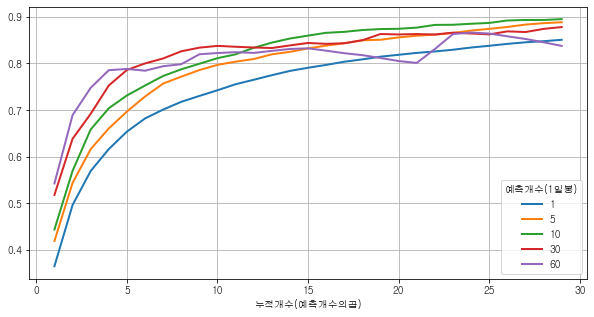

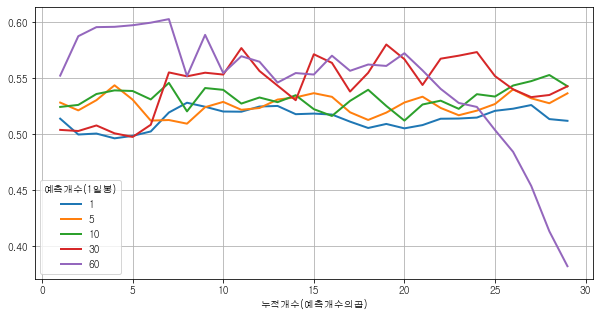

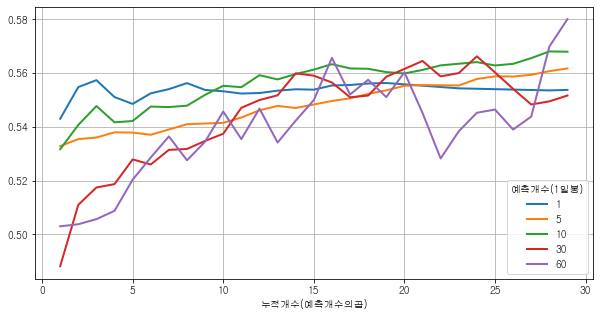

In [25]:
df_result = pd.DataFrame(preroll_list).sort_values('pred', ascending=False)
df_pivot = df_result.pivot(index='precount_x', columns='precount', values='pred')
df_pivot.index.rename('누적개수(예측개수의곱)', inplace=True)
df_pivot.columns.rename('예측개수(1일봉)', inplace=True)
df_pivot.plot(figsize=(10,5))

df_result = pd.DataFrame(preroll_list).sort_values('pred_c', ascending=False)
df_pivot = df_result.pivot(index='precount_x', columns='precount', values='pred_c')
df_pivot.index.rename('누적개수(예측개수의곱)', inplace=True)
df_pivot.columns.rename('예측개수(1일봉)', inplace=True)
df_pivot.plot(figsize=(10,5))

df_result = pd.DataFrame(preroll_list).sort_values('pred_r', ascending=False)
df_pivot = df_result.pivot(index='precount_x', columns='precount', values='pred_r')
df_pivot.index.rename('누적개수(예측개수의곱)', inplace=True)
df_pivot.columns.rename('예측개수(1일봉)', inplace=True)
df_pivot.plot(figsize=(10,5))

In [26]:
dft = df_raw.copy()
precount = 60
i = 4
rollcount = precount * i # 예측구간 롤링
# 밴드 생성
dft['rolling_High'] = dft['High'].shift(precount).rolling(window=rollcount, min_periods=1).max() 
dft['rolling_Low'] = dft['Low'].shift(precount).rolling(window=rollcount, min_periods=1).min()
# dft['rolling_High'] = dft['High'].shift(precount).apply(weightedMean(wts))
# dft['rolling_Low'] = dft['Low'].shift(precount).apply(weightedMean(wts))
i = 6
rollcount = precount * i # 예측구간 롤링
# 밴드 생성
# dft['rolling_High_'] = dft['High'].shift(precount).rolling(window=rollcount, min_periods=1).max() 
# dft['rolling_Low_'] = dft['Low'].shift(precount).rolling(window=rollcount, min_periods=1).min()
dft['rolling_Close'] = dft['Close'].shift(precount).rolling(window=rollcount, min_periods=1).mean()
# 추세 체크
# dft['rolling_mean'] = (((dft['Close'].shift(-precount) < dft['rolling_Close']) &
#                        (dft['rolling_Close']-dft['rolling_Low_'] < dft['rolling_High_']-dft['rolling_Close'])) |
#                        ((dft['Close'].shift(-precount) > dft['rolling_Close']) &
#                        (dft['rolling_Close']-dft['rolling_Low_'] > dft['rolling_High_']-dft['rolling_Close'])))

def fun(df):
    if (df['rolling_Close']-df['rolling_Low'] < df['rolling_High']-df['rolling_Close']):
        return -1
    elif (df['rolling_Close']-df['rolling_Low'] > df['rolling_High']-df['rolling_Close']):
        return 1
    return 0
dft['rolling_mean'] = dft.apply(lambda x:fun(x), axis=1)

i = 7
rollcount = precount * i # 예측구간 롤링
# 밴드 생성
# dft['rolling_High_'] = dft['High'].shift(precount).rolling(window=rollcount, min_periods=1).max() 
# dft['rolling_Low_'] = dft['Low'].shift(precount).rolling(window=rollcount, min_periods=1).min()
# dft['rolling_Close_'] = dft['Close'].shift(precount).rolling(window=rollcount, min_periods=1).mean()
dft['rolling_Range_'] = dft['rolling_High']-dft['rolling_Low']
dft['target'] = dft['Close'].shift(precount) - dft['rolling_Range_'] * 0.5
#변동성 체크
# dft['rolling_range'] = (((dft['Close'].shift(-precount) < dft['rolling_Close_']) &
#                        (dft['Close'] < dft['target'])) |
#                        ((dft['Close'].shift(-precount) > dft['rolling_Close_']) &
#                        (dft['Close'] > dft['target'])))
def fun(df):
    if (df['Close'] < df['target']):
        return -1
    elif (df['Close'] > df['target']):
        return 1
    return 0
dft['rolling_range'] = dft.apply(lambda x:fun(x), axis=1)
# dft['rolling_Close'] = dft['Close'].shift(precount).apply(weightedMean(wts))

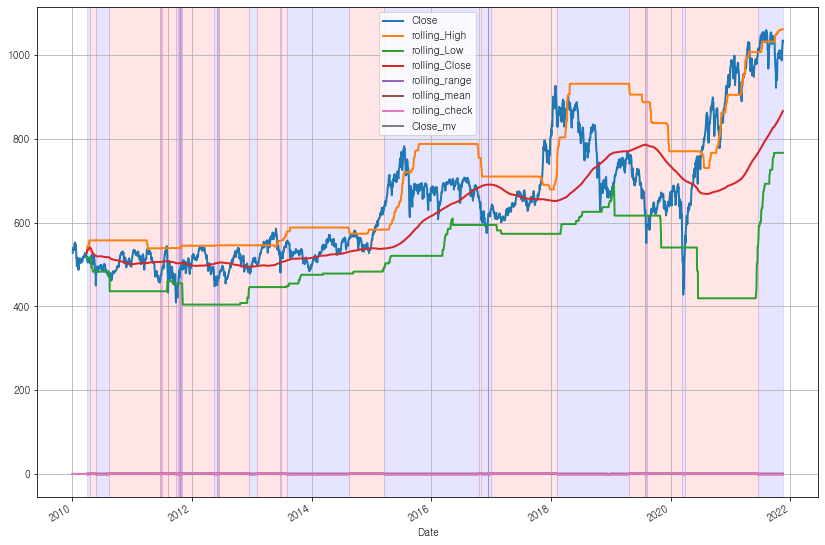

In [27]:
def fun(df):
    if df['rolling_range'] == -1 or df['rolling_mean'] == -1:
        return -1
    elif df['rolling_range'] == 1 and df['rolling_mean'] == 1:
        return 1
    return 0
dft['rolling_check'] = dft.apply(lambda x:fun(x), axis=1)
ax = pd.DataFrame(dft , columns=['Close','rolling_High','rolling_Low','rolling_Close','rolling_range','rolling_mean', 'rolling_check','Close_mv']).plot()

cur_i = None
cur_v = None
for i, v in dft['rolling_check'].iteritems():
    if cur_v != v:
        if cur_v == 1:
            color = 'red'    
            ax.axvspan(cur_i, i, color=color, alpha=0.1)
        elif cur_v == -1:
            color = 'blue'    
            ax.axvspan(cur_i, i, color=color, alpha=0.1)
        elif cur_v == 0:
            pass
        cur_i = i
    cur_v = v
if cur_v == 1:
    color = 'red'    
    ax.axvspan(cur_i, i, color=color, alpha=0.1)
elif cur_v == -1:
    color = 'blue'    
    ax.axvspan(cur_i, i, color=color, alpha=0.1)
elif cur_v == 0:
    pass

In [184]:
dft['rolling_check'] = 0

In [208]:
# 상승장 유형 ROE1EPS0영업이익_성장률_QOQ1영업이익_성장률_YOY1
# 횡보장 유형 GPA1PSR0자산성장률_QOQ1시가총액0
# 하락장 유형 ROE1EPS0영업이익_성장률_QOQ1시가총액0	
back_df = pd.DataFrame(dft, columns=['rolling_check'])
back_df['rolling_check'] = back_df['rolling_check'].shift(-precount).rolling(window=60, min_periods=1).mean()

In [201]:
display(df[df['시장'] == 1].sort_values('순위', ascending=True).head())
display(df[df['시장'] == 0].sort_values('순위', ascending=True).head())
display(df[df['시장'] == -1].sort_values('순위', ascending=True).head())

,유형,분기수,순위,최선순위,최악순위,평균수익률,승률,승리수,단일종목최대수익률,단일종목최대손실률,대상수,시장
89423,ROE1EPS0영업이익_성장률_QOQ1영업이익_성장률_YOY1,4,5309,1623,7223,40.618,0.8125,16,2.217116,-0.260314,20,1
13406,ROA1POR1매출액_성장률_YOY1시가총액0,4,5474,1383,10526,41.201,0.9000,18,3.133589,-0.141404,20,1
68471,BPS0당기순이익_성장률_QOQ1당기순이익_성장률_YOY1,4,6569,1953,12143,40.683,0.8375,16,2.489264,-0.243074,20,1
68245,ROE1EPS0당기순이익_성장률_YOY1자산성장률_QOQ1,4,7129,4857,12299,38.413,0.8375,16,2.489264,-0.243074,20,1
88870,ROE1POR1매출액_성장률_YOY1시가총액0,4,7482,2331,11604,38.887,0.8750,17,3.133589,-0.256338,20,1


,유형,분기수,순위,최선순위,최악순위,평균수익률,승률,승리수,단일종목최대수익률,단일종목최대손실률,대상수,시장
292057,GPA1PSR0자산성장률_QOQ1시가총액0,20,20369,374,69240,15.914,0.664444,13,2.518519,-0.397667,20,0
227906,GPA1POR0영업이익_성장률_YOY1시가총액0,20,23516,906,81625,13.742,0.654342,13,2.518519,-0.354582,20,0
227890,GPA1EPS1PER0시가총액0,20,23555,680,69117,13.405,0.650789,12,2.324201,-0.354582,20,0
337349,부채비율1영업이익_성장률_YOY1당기순이익_성장률_YOY1시가총액0,20,24485,2935,72824,13.268,0.651579,13,3.150538,-0.454724,20,0
58899,ROE1GPA1PBR0시가총액0,20,25268,115,111276,14.456,0.680921,13,2.145763,-0.226107,20,0


,유형,분기수,순위,최선순위,최악순위,평균수익률,승률,승리수,단일종목최대수익률,단일종목최대손실률,대상수,시장
346923,ROE1EPS0영업이익_성장률_QOQ1시가총액0,8,7260,206,18980,11.847,0.536184,10,3.050074,-0.466793,20,-1
330936,매출액_성장률_QOQ1영업이익_성장률_YOY1당기순이익_성장률_YOY1시가총액0,8,9456,488,24243,9.475,0.562829,11,1.941667,-0.450000,20,-1
346926,BPS0EPS1영업이익_성장률_QOQ1시가총액0,8,11587,1391,31776,8.947,0.534795,10,2.972414,-0.466793,20,-1
1044640,PBR_역수0당기순이익_성장률_YOY1베타0시가총액0,8,11782,413,36808,12.906,0.583553,11,4.144737,-0.710588,20,-1
1044639,PBR1당기순이익_성장률_YOY1베타0시가총액0,8,11782,412,36807,12.906,0.583553,11,4.144737,-0.710588,20,-1


In [209]:
tp_1 = 'ROE1EPS0영업이익_성장률_QOQ1영업이익_성장률_YOY1'
tp_0 = 'GPA1PSR0자산성장률_QOQ1시가총액0'
tp__1 = 'ROE1EPS0영업이익_성장률_QOQ1시가총액0'
back_df = df20[df20['유형'].isin([tp_1, tp_0, tp__1])]

In [210]:
dft_result = dft.shift(-precount).copy().reset_index()
# dft_result = dft.copy().reset_index()
back_result = pd.merge(back_df, dft_result, how='left', left_on='매수날짜', right_on='Date')

In [215]:
back_result = back_result[back_result['매수날짜'] > '2018-01-01']

In [216]:
back_result = back_result[((back_result['rolling_check'] <= 1) & (back_result['rolling_check'] > 0.2) & (back_result['유형'] == tp_1)) |
((back_result['rolling_check'] <= 0.2) & (back_result['rolling_check'] >= -0.2) & (back_result['유형'] == tp_0)) |
((back_result['rolling_check'] < 0.2) & (back_result['rolling_check'] >= -1) & (back_result['유형'] == tp__1))]
back_result

,순위,유형,대상수,날짜,매수날짜,평균수익률,표준편차,총거래,승률,승리수,...,Change,rolling_High,rolling_Low,rolling_Close,rolling_mean,rolling_Range_,target,rolling_range,rolling_check,x_Close
1,41010,GPA1PSR0자산성장률_QOQ1시가총액0,20,2020-05-18,2020-03-31,28.456,0.126573,18,1.000000,18,...,-0.0212,770.66,419.55,673.173306,1.0,351.11,393.515,1.0,0.0,569.07
2,206,ROE1EPS0영업이익_성장률_QOQ1시가총액0,20,2019-11-15,2019-08-16,31.544,0.363411,19,0.947368,18,...,0.0022,837.97,540.83,757.310778,1.0,297.14,443.000,1.0,0.0,591.57
4,31972,ROE1EPS0영업이익_성장률_QOQ1시가총액0,20,2020-05-18,2020-03-31,29.957,0.237553,20,0.900000,18,...,-0.0212,770.66,419.55,673.173306,1.0,351.11,393.515,1.0,0.0,569.07
6,9701,ROE1EPS0영업이익_성장률_QOQ1시가총액0,20,2020-11-16,2020-08-18,29.126,0.182685,20,0.950000,19,...,0.0098,863.80,419.55,680.811694,1.0,444.25,578.095,1.0,0.0,800.22
9,21312,GPA1PSR0자산성장률_QOQ1시가총액0,20,2020-11-16,2020-08-18,23.646,0.224107,19,0.894737,17,...,0.0098,863.80,419.55,680.811694,1.0,444.25,578.095,1.0,0.0,800.22
15,39278,GPA1PSR0자산성장률_QOQ1시가총액0,20,2019-11-15,2019-08-16,14.583,0.214867,18,0.777778,14,...,0.0022,837.97,540.83,757.310778,1.0,297.14,443.000,1.0,0.0,591.57
20,1039,ROE1EPS0영업이익_성장률_QOQ1시가총액0,20,2019-04-01,2018-11-15,36.508,0.664108,19,0.947368,18,...,-0.0049,932.01,617.00,768.882139,-1.0,315.01,523.875,1.0,0.0,681.38
23,41840,GPA1PSR0자산성장률_QOQ1시가총액0,20,2020-08-18,2020-05-18,20.366,0.338467,20,0.750000,15,...,0.0060,730.86,419.55,668.759806,1.0,311.31,535.195,1.0,0.0,690.85
24,2586,GPA1PSR0자산성장률_QOQ1시가총액0,20,2019-04-01,2018-11-15,32.262,0.654143,20,0.850000,17,...,-0.0049,932.01,617.00,768.882139,-1.0,315.01,523.875,1.0,0.0,681.38
32,18980,ROE1EPS0영업이익_성장률_QOQ1시가총액0,20,2019-05-16,2019-04-01,4.955,0.138766,19,0.631579,12,...,-0.0157,906.06,617.00,781.842583,1.0,289.06,592.280,1.0,0.0,736.81


In [217]:
back_result['평균수익률'].mean()

15.941250000000002

In [197]:
round(back_result.mean(numeric_only=True), 3)

순위                2.608650e+04
대상수               2.000000e+01
평균수익률             1.479200e+01
표준편차              3.140000e-01
총거래               1.964100e+01
승률                6.430000e-01
승리수               1.257800e+01
단일종목최대수익률         1.129000e+00
단일종목최대손실률        -1.850000e-01
Close             6.771120e+02
Open              6.794950e+02
High              6.832280e+02
Low               6.729000e+02
Volume            5.509552e+08
Change           -0.000000e+00
rolling_High      7.462390e+02
rolling_Low       5.313410e+02
rolling_Close     6.417600e+02
rolling_mean      0.000000e+00
rolling_Range_    2.148980e+02
target            5.573790e+02
rolling_range     9.380000e-01
rolling_check     0.000000e+00
x_Close           6.648280e+02
dtype: float64

In [48]:
df = df_raw[(df_raw['평균수익률'] > 0) & (df_raw['대상수'] == 20)]

In [49]:
df['평균수익률'] = round(df['평균수익률'] * 100, 3)

In [50]:
df.sort_values('순위', ascending=True, inplace=True)
df

,유형,분기수,순위,최선순위,최악순위,평균수익률,승률,승리수,단일종목최대수익률,단일종목최대손실률,대상수,시장
89423,ROE1EPS0영업이익_성장률_QOQ1영업이익_성장률_YOY1,4,5309,1623,7223,40.618,0.812500,16,2.217116,-0.260314,20,1
13406,ROA1POR1매출액_성장률_YOY1시가총액0,4,5474,1383,10526,41.201,0.900000,18,3.133589,-0.141404,20,1
68471,BPS0당기순이익_성장률_QOQ1당기순이익_성장률_YOY1,4,6569,1953,12143,40.683,0.837500,16,2.489264,-0.243074,20,1
68245,ROE1EPS0당기순이익_성장률_YOY1자산성장률_QOQ1,4,7129,4857,12299,38.413,0.837500,16,2.489264,-0.243074,20,1
346923,ROE1EPS0영업이익_성장률_QOQ1시가총액0,8,7260,206,18980,11.847,0.536184,10,3.050074,-0.466793,20,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
283277,BPS0순차입금비율1자산성장률_QOQ0시가총액1,4,151407,145667,155179,3.236,0.516447,10,0.581081,-0.394209,20,1
288421,ROE0BPS0POR0주가변동성1,4,151786,146750,155753,2.263,0.478582,9,1.105672,-0.394209,20,1
288422,ROA0BPS0POR0주가변동성1,4,151898,147322,155738,1.824,0.477851,9,1.105672,-0.394209,20,1
291202,ROA0BPS0영업이익_성장률_QOQ0시가총액1,4,152551,148272,154617,3.820,0.509211,10,0.963899,-0.394209,20,1


In [35]:
df[df['시장'] == 1].sort_values('순위', ascending=True)

,유형,분기수,순위,최선순위,최악순위,평균수익률,승률,승리수,단일종목최대수익률,단일종목최대손실률,대상수,시장
1275569,PER1당기순이익_성장률_YOY1베타1시가총액0,4,2895,711,6294,30.199,0.842500,168,10.841270,-1.000000,200,1
1275719,ROE1당기순이익_성장률_YOY1베타1시가총액0,4,3315,1007,7387,29.606,0.852500,170,2.489264,-1.000000,200,1
1276003,부채비율1당기순이익_성장률_YOY1베타1시가총액0,4,4183,3139,5428,28.933,0.837331,166,3.559342,-1.000000,200,1
1276026,ROE1부채비율1주가변동성1시가총액0,4,4414,2791,6843,28.892,0.825641,163,3.559342,-1.000000,200,1
115421,매출액_성장률_YOY1당기순이익_성장률_QOQ1시가총액0,4,4459,1168,7715,32.492,0.874646,87,10.841270,-0.276995,100,1
...,...,...,...,...,...,...,...,...,...,...,...,...
465480,BPS1PBR1베타0,4,153325,147110,155783,10.778,0.689076,136,1.267327,-0.519286,200,1
465481,BPS1PBR_역수0베타0,4,153325,147110,155783,10.778,0.689076,136,1.267327,-0.519286,200,1
182935,PER1베타0주가변동성0시가총액1,4,153385,152140,155429,11.826,0.719879,142,1.417154,-0.319544,200,1
182939,EPS1PER1베타0,4,153447,151252,155561,11.738,0.723024,143,1.909483,-0.319544,200,1
